In [2]:
import pickle
import pandas as pd
import os
import numpy as np
import import_ipynb
from feeds import BackFeed,DataFeed
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import graphviz
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
from decision_tree import DecisionTree

importing Jupyter notebook from feeds.ipynb
importing Jupyter notebook from synfeed.ipynb
importing Jupyter notebook from india_calendar.ipynb
importing Jupyter notebook from featfuncs.ipynb


In [20]:
config_name = 'rl_02'
modelname = 'RLC0.pth'
datafolder_name = 'alldata'

test_path = os.path.join('results', config_name, 'test', modelname, 'realdata', datafolder_name, 'bt.pkl')
feed_path = os.path.join('..', 'algodata', 'realdata', f'datafeed_{datafolder_name}_True_False.pkl')

data_1 = pickle.load(open(test_path, 'rb'))
feed = pickle.load(open(feed_path, 'rb')).data

In [21]:
for ticker in feed:
    feed[ticker]['row_num'] = feed[ticker]['row_num'].apply(lambda x: x if x<75 else x-75)

### high - low, open - close, open - open prev, sma 20 - sma 10, open - high, slope (window size on all the features, slopes on all the features)

In [22]:
columns = ['datetime', 'Date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume',
       'row_num', 'Open_n', 'High_n', 'Low_n', 'Close_n', 'Volume_n', 'SMA_10',
       'SMA_20', 'VOL_SMA_20', 'RSI_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
       'BBB_5_2.0', 'BBP_5_2.0', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'VWAP_D', 'MOM_30', 'CMO_14', 'error', 'sym']

columns_to_use = ['Open', 'High', 'Low', 'Close', 'Volume', 'row_num', 'Open_n', 
                  'High_n', 'Low_n', 'Close_n', 'Volume_n', 'SMA_10',
       'SMA_20', 'VOL_SMA_20', 'RSI_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
       'BBB_5_2.0', 'BBP_5_2.0', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'VWAP_D', 'MOM_30', 'CMO_14']

In [23]:
def check_numeric(df, col):
    return df[col].dtype in ['float64', 'int64']

def difference_cols(df, a, b):
    df[f'{a}-{b}'] = df[a] - df[b]
    return df, f'{a}-{b}'

def get_ma_base_string(s):
    idx = s.find('_ma_')
    if idx == -1:
        return None
    return s[:idx]

def moving_avg(df, col, window_size=3, center=False):
    col_name = f'{col}_ma_{window_size}'
    df[col_name] = df[col].rolling(window_size, min_periods=1, center=center).mean()
    return df, col_name

def slope(df, col, window):
    col_name = f'{col}_slope_{window}'
    df[col_name] = df[col].diff(periods=window).fillna(df[col])/window
    return df, col_name

def max_change_helper(seq):
    ans = []
    tracker = {i:0 for i in range(seq[-1]+1)}
    for i in seq:
        tracker[i] += 1
        ans.append(tracker[i])
    return ans

def max_change(df, col):
    inc_tracker = df[col].diff().lt(0).cumsum().values
    dec_tracker = df[col].diff().gt(0).cumsum().values
    
    inc_values = max_change_helper(inc_tracker)
    dec_values = max_change_helper(dec_tracker)
    
    combined = [inc_values[i]-1 if inc_values[i] >= dec_values[i] \
                else -dec_values[i]+1 for i in range(len(inc_values))]
    
    col_name = f'{col}_changelen'
    df[col_name] = combined
    return df, col_name

def discretize(df, col):
    stats = df[col].describe()
    low_thresh, high_thresh = stats['25%'], stats['75%']
    df[f'{col}_val'] = df[col].apply(lambda x: 0 if x<=low_thresh else 2 if x>=high_thresh else 1)
    df[f'{col}_polarity'] = df[col].apply(lambda x: 1 if x>0 else -1)
    # df[f'{col}_discrete'] = df[f'{col}_val'] + df[f'{col}_polarity']
    return df, [f'{col}_val', f'{col}_polarity'] #, f'{col}_discrete']

### Inter-column Differences

In [24]:
subtract_col_names = [('High', 'Low'), ('Open', 'Close'), ('SMA_20', 'SMA_10'), ('Open_n', 'Close_n'), ('High_n', 'Low_n'), ('Open', 'High')]
subtract_cols = []

for ticker in feed:
    for cols in subtract_col_names:
        feed[ticker], added_col = difference_cols(feed[ticker], cols[0], cols[1])
        if added_col not in subtract_cols: subtract_cols.append(added_col)
    
feed['AARTIDRUGS.NS'].head(2)

,Open,High,Low,Close,Volume,Datetime,ticker,Date,Dividends,Stock Splits,...,MOM_30,CMO_14,error,sym,High-Low,Open-Close,SMA_20-SMA_10,Open_n-Close_n,High_n-Low_n,Open-High
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,504.500000,504.500000,508.049988,507.200012,2341.0,2022-02-02 09:15:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.010325,49.647261,-1,1,-3.549988,-2.700012,-0.000134,-0.005361,-0.007049,0.000000
2022-02-02 09:20:00+05:30,507.149994,507.049988,510.500000,510.500000,2847.0,2022-02-02 09:20:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.016877,63.608787,-1,1,-3.450012,-3.350006,-0.000809,-0.006651,-0.006850,0.100006


### Moving Average Calculation

In [27]:
window_sizes = [1,5,10,20,50]
pre_avg_cols = columns_to_use + subtract_cols
avg_cols = []

for ticker in feed:
    for window in window_sizes:
        for col in pre_avg_cols:
            feed[ticker], added_col = moving_avg(feed[ticker], col, window_size=window)
            if added_col not in avg_cols: avg_cols.append(added_col)
            
feed['AARTIDRUGS.NS'].head(2)

,Open,High,Low,Close,Volume,Datetime,ticker,Date,Dividends,Stock Splits,...,MACDs_12_26_9_ma_50,VWAP_D_ma_50,MOM_30_ma_50,CMO_14_ma_50,High-Low_ma_50,Open-Close_ma_50,SMA_20-SMA_10_ma_50,Open_n-Close_n_ma_50,High_n-Low_n_ma_50,Open-High_ma_50
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,504.500000,504.500000,508.049988,507.200012,2341.0,2022-02-02 09:15:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.000403,1.005824,0.010325,49.647261,-3.549988,-2.700012,-0.000134,-0.005361,-0.007049,0.000000
2022-02-02 09:20:00+05:30,507.149994,507.049988,510.500000,510.500000,2847.0,2022-02-02 09:20:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.000555,1.007331,0.013601,56.628024,-3.500000,-3.025009,-0.000472,-0.006006,-0.006949,0.050003


In [28]:
print(len(columns_to_use), len(subtract_cols), len(avg_cols))

26 6 160


### Slopes

In [29]:
pre_slope_cols = columns_to_use + subtract_cols + avg_cols
window_sizes = [1,3,5,10,15]
slope_cols = []

for t in feed:
    for window in window_sizes:
        for col in pre_slope_cols:
            feed[t], added_col = slope(feed[t], col, window=window)
            if added_col not in slope_cols: slope_cols.append(added_col)

feed['AARTIDRUGS.NS'].head(2)

,Open,High,Low,Close,Volume,Datetime,ticker,Date,Dividends,Stock Splits,...,MACDs_12_26_9_ma_50_slope_15,VWAP_D_ma_50_slope_15,MOM_30_ma_50_slope_15,CMO_14_ma_50_slope_15,High-Low_ma_50_slope_15,Open-Close_ma_50_slope_15,SMA_20-SMA_10_ma_50_slope_15,Open_n-Close_n_ma_50_slope_15,High_n-Low_n_ma_50_slope_15,Open-High_ma_50_slope_15
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,504.500000,504.500000,508.049988,507.200012,2341.0,2022-02-02 09:15:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.000027,0.067055,0.000688,3.309817,-0.236666,-0.180001,-0.000009,-0.000357,-0.000470,0.000000
2022-02-02 09:20:00+05:30,507.149994,507.049988,510.500000,510.500000,2847.0,2022-02-02 09:20:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.000037,0.067155,0.000907,3.775202,-0.233333,-0.201667,-0.000031,-0.000400,-0.000463,0.003334


### Difference between moving averages of different lengths

In [30]:
intra_ma_diff_cols = []

for t in feed:
    for i in range(len(avg_cols)-1):
        for j in range(i+1, len(avg_cols)):
            colA, colB = avg_cols[i], avg_cols[j]
            baseA, baseB = get_ma_base_string(colA), get_ma_base_string(colB)
            if baseA != baseB: continue
            
            feed[t], added_col = difference_cols(feed[t], colA, colB)
            if added_col not in intra_ma_diff_cols: intra_ma_diff_cols.append(added_col)
    
feed['AARTIDRUGS.NS'].head(2)

,Open,High,Low,Close,Volume,Datetime,ticker,Date,Dividends,Stock Splits,...,MACDs_12_26_9_ma_20-MACDs_12_26_9_ma_50,VWAP_D_ma_20-VWAP_D_ma_50,MOM_30_ma_20-MOM_30_ma_50,CMO_14_ma_20-CMO_14_ma_50,High-Low_ma_20-High-Low_ma_50,Open-Close_ma_20-Open-Close_ma_50,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50,High_n-Low_n_ma_20-High_n-Low_n_ma_50,Open-High_ma_20-Open-High_ma_50
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,504.500000,504.500000,508.049988,507.200012,2341.0,2022-02-02 09:15:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-02 09:20:00+05:30,507.149994,507.049988,510.500000,510.500000,2847.0,2022-02-02 09:20:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get Increasing/Decreasing Length

In [31]:
pre_change_cols = columns_to_use + subtract_cols + avg_cols + slope_cols + intra_ma_diff_cols
change_cols = []

for t in feed:
    for col in pre_change_cols:
        feed[t], added_col = max_change(feed[t], col)
        if added_col not in change_cols: change_cols.append(added_col)
    
feed['AARTIDRUGS.NS'].head(2)

,Open,High,Low,Close,Volume,Datetime,ticker,Date,Dividends,Stock Splits,...,MACDs_12_26_9_ma_20-MACDs_12_26_9_ma_50_changelen,VWAP_D_ma_20-VWAP_D_ma_50_changelen,MOM_30_ma_20-MOM_30_ma_50_changelen,CMO_14_ma_20-CMO_14_ma_50_changelen,High-Low_ma_20-High-Low_ma_50_changelen,Open-Close_ma_20-Open-Close_ma_50_changelen,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen,Open-High_ma_20-Open-High_ma_50_changelen
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,504.500000,504.500000,508.049988,507.200012,2341.0,2022-02-02 09:15:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2022-02-02 09:20:00+05:30,507.149994,507.049988,510.500000,510.500000,2847.0,2022-02-02 09:20:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1


### Discretization

In [32]:
pre_discrete_cols = pre_change_cols + change_cols
discrete_cols = []

for t in feed:
    for col in pre_discrete_cols:
        feed[t], added_cols = discretize(feed[t], col)
        for added_col in added_cols: 
            if added_col not in discrete_cols: discrete_cols.append(added_col)
    
feed['AARTIDRUGS.NS'].head(2)

,Open,High,Low,Close,Volume,Datetime,ticker,Date,Dividends,Stock Splits,...,Open-Close_ma_20-Open-Close_ma_50_changelen_val,Open-Close_ma_20-Open-Close_ma_50_changelen_polarity,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen_val,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen_polarity,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen_val,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen_polarity,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen_val,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen_polarity,Open-High_ma_20-Open-High_ma_50_changelen_val,Open-High_ma_20-Open-High_ma_50_changelen_polarity
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,504.500000,504.500000,508.049988,507.200012,2341.0,2022-02-02 09:15:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,1,-1,1,-1,1,-1,1,-1,1,-1
2022-02-02 09:20:00+05:30,507.149994,507.049988,510.500000,510.500000,2847.0,2022-02-02 09:20:00+05:30,AARTIDRUGS.NS,02-Feb-2022,1.0,1.0,...,2,1,1,1,2,1,1,1,1,1


In [33]:
len(discrete_cols)

5888

### Adding Action Taken by Agent

### 0: Wait, 1: Buy, 2:Sell

In [34]:
for ticker in feed:
    feed[ticker]['Action'] = -5
    actions = []

    for t in data_1[ticker]:
        for acts in data_1[ticker][t]['acts']:
            a, rn = acts[0], acts[-1]
            actions.append(a)
            # if a == -1: a = 2
            feed[ticker].loc[(feed[ticker]['Date']==t) & (feed[ticker]['row_num']==rn), 'Action'] = a

In [35]:
feed_old = feed.copy()
feed = pd.concat([feed[t] for t in feed], axis=0)
feed

,Open,High,Low,Close,Volume,Datetime,ticker,Date,Dividends,Stock Splits,...,Open-Close_ma_20-Open-Close_ma_50_changelen_polarity,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen_val,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen_polarity,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen_val,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen_polarity,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen_val,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen_polarity,Open-High_ma_20-Open-High_ma_50_changelen_val,Open-High_ma_20-Open-High_ma_50_changelen_polarity,Action
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,84.949997,84.949997,85.849998,85.300003,1756.0,2022-02-02 09:15:00+05:30,NELCAST.NS,02-Feb-2022,1.0,1.0,...,-1,1,-1,1,-1,1,-1,1,-1,-5
2022-02-02 09:21:00+05:30,85.250000,85.250000,85.550003,85.449997,5107.0,2022-02-02 09:21:00+05:30,NELCAST.NS,02-Feb-2022,1.0,1.0,...,1,1,1,2,1,1,1,1,1,-5
2022-02-02 09:26:00+05:30,85.349998,84.000000,85.349998,84.199997,13373.0,2022-02-02 09:26:00+05:30,NELCAST.NS,02-Feb-2022,1.0,1.0,...,1,1,1,2,1,2,1,2,1,-5
2022-02-02 09:31:00+05:30,84.800003,84.650002,85.300003,85.099998,4370.0,2022-02-02 09:31:00+05:30,NELCAST.NS,02-Feb-2022,1.0,1.0,...,1,1,1,2,1,2,1,2,1,-5
2022-02-02 09:36:00+05:30,85.150002,84.949997,85.250000,84.949997,1418.0,2022-02-02 09:36:00+05:30,NELCAST.NS,02-Feb-2022,1.0,1.0,...,1,1,1,2,1,2,1,2,1,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23 15:08:00+05:30,837.799988,836.000000,839.700012,836.299988,1069.0,2021-12-23 15:08:00+05:30,SOMANYCERA.NS,23-Dec-2021,1.0,1.0,...,1,1,1,2,1,1,-1,2,1,-5
2021-12-23 15:14:00+05:30,836.250000,832.700012,836.900024,835.000000,4322.0,2021-12-23 15:14:00+05:30,SOMANYCERA.NS,23-Dec-2021,1.0,1.0,...,-1,1,1,0,-1,1,-1,0,-1,-5
2021-12-23 15:19:00+05:30,835.049988,834.950012,837.000000,836.849976,2292.0,2021-12-23 15:19:00+05:30,SOMANYCERA.NS,23-Dec-2021,1.0,1.0,...,1,1,1,2,1,0,-1,1,1,-5


In [36]:
feed['Action'].value_counts()

-5    91900
-1     2506
 1      683
Name: Action, dtype: int64

### Creating Final DataFrame

In [47]:
df = feed[feed['Action']!=-5]
labels = ['sell', 'buy']

### Training a DT

In [48]:
def trainDT(X_train, X_test, y_train, y_test, cols_to_use, y_col, max_depth=2):
    # Fit the classifier with default hyper-parameters
    clf = DecisionTreeClassifier(max_depth=max_depth)
    model = clf.fit(X_train, y_train)
    
    # DOT data
    dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=cols_to_use,
                                    class_names=labels,
                                    filled=True)
    # Draw graph
    graph = graphviz.Source(dot_data, format="png")
    preds = clf.predict(X_test)
    cm = pd.DataFrame(confusion_matrix(y_test, preds), columns=labels, index=labels)
    report = classification_report(y_test, preds, target_names=labels)
    
    return graph, cm, report

In [49]:
discrete_non_raw = [col for col in discrete_cols if col.rstrip('_polarity').rstrip('_val') not in columns_to_use]
len(discrete_non_raw)

5836

[INFO] Using 5704 columns!


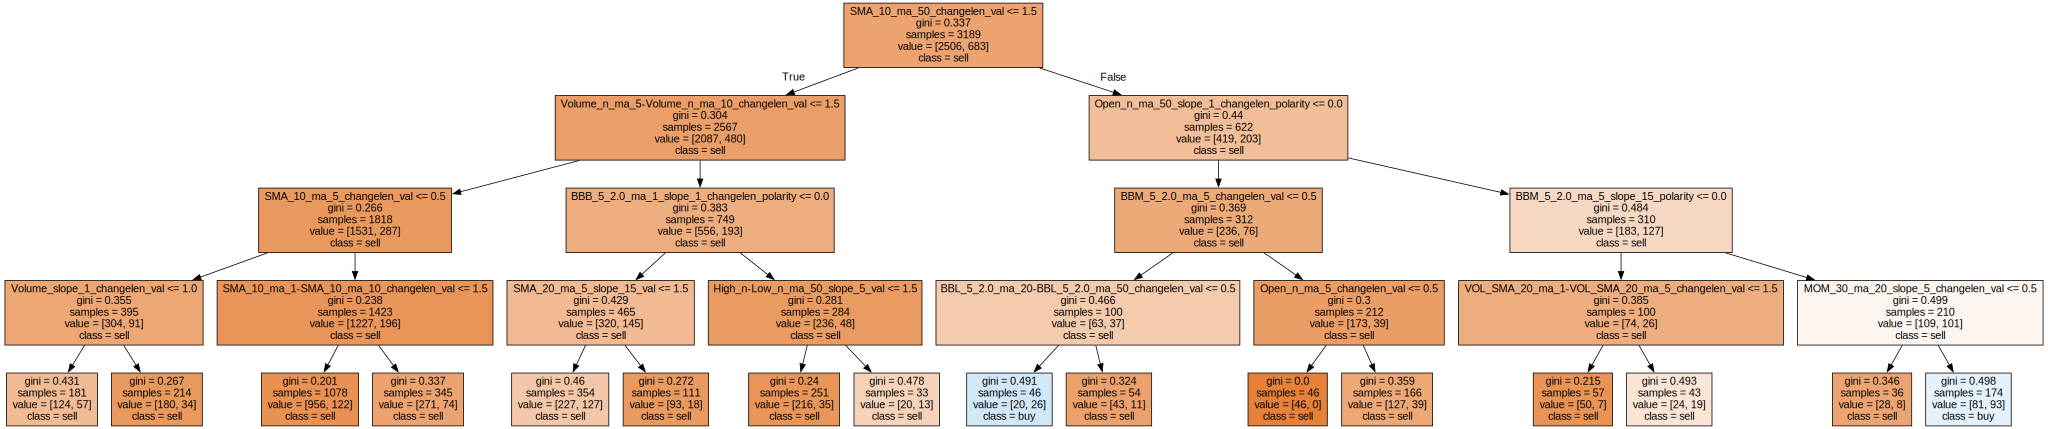

In [70]:
COLS_TO_USE =  [col for col in discrete_cols if not col.startswith('row_num')]
print(f'[INFO] Using {len(COLS_TO_USE)} columns!')
y_col='Action'

n = len(df)
X = df.loc[:, COLS_TO_USE]
y = df.loc[:, y_col]

X_train, X_test, y_train, y_test = X.iloc[:n//2], X.iloc[n//2:], y.iloc[:n//2].values, y.iloc[n//2:].values

# graph, cm, report = trainDT(X_train, X_test, y_train, y_test, COLS_TO_USE, y_col=y_col, max_depth=2)
graph, cm, report = trainDT(X, X, y, y, COLS_TO_USE, y_col=y_col, max_depth=4) 
graph

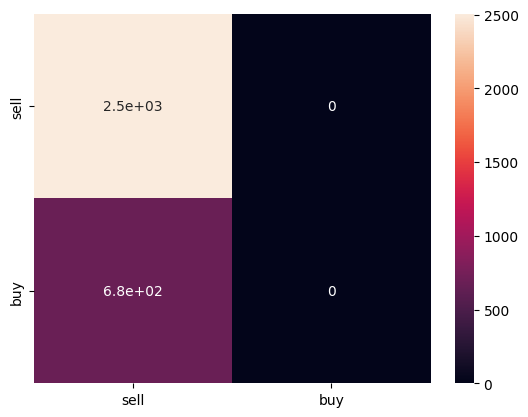

In [52]:
sns.heatmap(cm, annot=True);

In [53]:
print(report)


              precision    recall  f1-score   support

        sell       0.79      1.00      0.88      2506
         buy       0.00      0.00      0.00       683

    accuracy                           0.79      3189
   macro avg       0.39      0.50      0.44      3189
weighted avg       0.62      0.79      0.69      3189



In [63]:
dt = DecisionTree(max_depth=2)
dt.train(X, y)

# dt.score(X_test, y.iloc[n//2:])

[INFO] Trained Tree!


In [64]:
dt.score(X, y)

              precision    recall  f1-score   support

          -1       0.79      1.00      0.88      2506
           1       0.00      0.00      0.00       683

    accuracy                           0.79      3189
   macro avg       0.39      0.50      0.44      3189
weighted avg       0.62      0.79      0.69      3189



/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [65]:
dt.visualize()

                                                                                                         Index: 0
                                                                                                         row_num_slope_15_changelen_polarity >= 1
                                                                                                         Gini: 0.3366066778036487
                                                                                                         Samples: 3189
                                                                                                         Values: {-1: 2506, 1: 683}
                                                                                                         Class: -1

                                   Index: 1                                                                                                                                    Index: 2
                                   BBU_5_2.0_ma_1-BBU_5_2.0

In [66]:
dt.prune(impurity_thresh=0.4, set_action=0)

[INFO] Pruned leaf with index: 3 as                           impurity=0.4852834028890922
[INFO] Prune leaf with index: 4 as                           impurity=0.4034434453610469
[INFO] Pruned leaf with index: 5 as                           impurity=0.27603486506255714
[INFO] Pruning complete!


In [67]:
dt.visualize()

                                                                                                         Index: 0
                                                                                                         row_num_slope_15_changelen_polarity >= 1
                                                                                                         Gini: 0.3366066778036487
                                                                                                         Samples: 3189
                                                                                                         Values: {-1: 2506, 1: 683}
                                                                                                         Class: -1

                                   Index: 1                                                                                                                                    Index: 2
                                   BBU_5_2.0_ma_1-BBU_5_2.0

In [28]:
dt.score(X, y)

              precision    recall  f1-score   support

          -1       0.93      0.84      0.88       432
           0       0.00      0.00      0.00         0
           1       0.97      0.77      0.86       490

    accuracy                           0.80       922
   macro avg       0.63      0.54      0.58       922
weighted avg       0.95      0.80      0.87       922



/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
dt.save('saved_models/dt_hp_11.pkl')

#### run the policy from the dt (after uncertainty removal) on real and synthetic data

#### run the rl on real data once more

#### get the optimal policy for real data and make a dt from that

#### Take synthetic rl + optimal real: train dt on different bags of the data, get some featuress, take the top 5 features, train a random forest (to get a policy)

#### don't take an action where the confidence is low (impurity/entropy is high) at the leaf

#### use this policy for testing on the real data

#### use the sequence (curr features, current and past timesteps) to predict the future (predict the correct action). 